# <span style="color: steelblue;">Differential Gene expression(DGE) analysis using scaLR </span>

- Differential gene expression (DGE) analysis is a method employed in genomics to evaluate and compare gene expression levels across different sample groups. This can include comparisons between healthy and diseased tissues or cells subjected to various treatments.

- In single-cell RNA-seq (scRNA-seq) data, the gene expression matrix is organized into various hierarchical groups. These groups may include regions from which samples were collected, clinical conditions such as different disease stages or normal states. For each individual subject in the study, RNA-seq generates a number of cells, with gene expression levels varying across different cell types.

- Major single-cell differential gene expression (scDGE) analysis approaches are : Pseudobulk, Mixed-effects models, and Differential distribution based methods. This tutorial explains how to perform scDGE analysis using scaLR DGE module which includes: ```Pseudobulk``` and ```Linear mixed-effects model```approaches.

## <span style="color: steelblue;">Imports</span>

In [35]:
import sys
# sys.path.append('/path/to/scaLR/')

In [36]:
import os
import pandas as pd
import scanpy as sc
from matplotlib_venn import venn2
import numpy as np
from scalr.analysis import dge_lmem
from scalr.analysis import dge_psedobulk
%reload_ext autoreload
%autoreload 2

## <span style="color: steelblue;">Loading of data and exploration</span>

In [37]:
dirpath = '/path/to/scaLR/tutorials/analysis/differential_gene_expression/'
adata = sc.read_h5ad(os.path.join(dirpath,'test_data.h5ad'),backed='r')

In [21]:
#Structure of the anndata
adata

AnnData object with n_obs × n_vars = 46209 × 5000 backed at '/home/amit.samal/scaLR_run/pipeline_latest/single_cell_classification/tutorials/analysis/differential_gene_expression/test_data.h5ad'
    obs: 'dsm_severity_score_group', 'disease_ontology_term_id', 'severity', 'tissue_ontology_term_id', 'timepoint', 'outcome', 'dsm_severity_score', 'days_since_hospitalized', 'age', 'donor_id', 'days_since_onset', 'author_cell_type', 'ever_admitted_to_icu', 'material_type', 'development_stage_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'mvp.mean', 'mvp.dispersion', 'mvp.dispersion.scaled', 'mvp.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biot

In [22]:
#Cell barcodes and metadata
adata.obs.head()

,dsm_severity_score_group,disease_ontology_term_id,severity,tissue_ontology_term_id,timepoint,outcome,dsm_severity_score,days_since_hospitalized,age,donor_id,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
AAACCTGAGAAACCTA-1_1,DSM_low,MONDO:0100096,Moderate,UBERON:0000178,T0,alive,-1.950858,1.0,55.0,HGR0000083,...,tissue,non-classical monocyte,10x 5' v1,COVID-19,Homo sapiens,male,blood,European,55-year-old human stage,!9L}G4hgnw
AAACCTGCACCTGGTG-1_1,DSM_high,MONDO:0100096,Critical,UBERON:0000178,T0,alive,2.954350,1.0,60.0,HGR0000098,...,tissue,"CD16-positive,CD56-dim_NK_cell",10x 5' v1,COVID-19,Homo sapiens,male,blood,European,60-year-old human stage,)*azge@M0l
AAACCTGTCAACCATG-1_1,DSM_low,MONDO:0100096,Moderate,UBERON:0000178,T0,alive,-2.910737,1.0,57.0,HGR0000136,...,tissue,"CD16-positive,CD56-dim_NK_cell",10x 5' v1,COVID-19,Homo sapiens,female,blood,European,57-year-old human stage,4Xgk?_edQm
AAACCTGTCGGAGCAA-1_1,DSM_high,MONDO:0100096,Critical,UBERON:0000178,T1,alive,0.051620,8.0,78.0,HGR0000089,...,tissue,"CD16-positive,CD56-dim_NK_cell",10x 5' v1,COVID-19,Homo sapiens,male,blood,European,78-year-old human stage,VhQgSjGzzo
AAACCTGTCTACGAGT-1_1,DSM_low,MONDO:0100096,Severe,UBERON:0000178,T0,alive,-1.201561,1.0,79.0,HGR0000137,...,tissue,natural killer cell,10x 5' v1,COVID-19,Homo sapiens,female,blood,European,79-year-old human stage,&aLPtO}^hY


In [38]:
# Gene information metadata
adata.var.head()

,mvp.mean,mvp.dispersion,mvp.dispersion.scaled,mvp.variable,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length
ENSG00000168454,0.000380,1.168876,0.181734,False,False,TXNDC2,NCBITaxon:9606,gene,3352
ENSG00000197852,0.035995,1.634179,0.886458,False,False,INKA2,NCBITaxon:9606,gene,6393
ENSG00000196878,0.008862,1.617729,0.861545,False,False,LAMB3,NCBITaxon:9606,gene,4647
ENSG00000256540,0.000022,1.660993,0.927070,False,False,IQSEC3-AS1,NCBITaxon:9606,gene,1184
ENSG00000139180,0.090100,1.184720,0.205731,False,False,NDUFA9,NCBITaxon:9606,gene,10391


In [24]:
#Information about subjects
adata.obs.donor_id.unique()

['HGR0000083', 'HGR0000098', 'HGR0000136', 'HGR0000089', 'HGR0000137', ..., 'HGR0000142', 'SHD5', 'HGR0000101', 'SHD6', 'HGR0000135']
Length: 46
Categories (46, object): ['AA220014', 'AA220534', 'AA220907', 'HDML', ..., 'SHD4', 'SHD5', 'SHD6', 'SHD7']

In [25]:
#Celltype information
adata.obs.cell_type.value_counts()

cell_type
CD16-positive,CD56-dim_NK_cell       28705
non-classical monocyte                6160
natural killer cell                   3825
platelet                              3370
CD16-negative,CD56-bright_NK_cell     1237
conventional dendritic cell            991
plasmacytoid dendritic cell            787
granulocyte                            776
intermediate monocyte                  358
Name: count, dtype: int64

In [26]:
#Clinical conditions 
adata.obs.disease.value_counts()

disease
COVID-19    33708
normal      12501
Name: count, dtype: int64

## <span style="color: steelblue;">1. DGE analysis : Pseudobulk method</span>

- ```Pseudobulk``` approach involves aggregating the unique molecular identifier (UMI) counts within each cell type of all
  subject, effectively creating a "pseudobulk" dataset.
- In this method, the scRNA-seq data is summarized to resemble bulk RNA-seq data, where the UMI counts from all cells
  of a specific type are combined for each subject.
- This aggregated dataset can then be analyzed using DGE methods designed for bulk RNA-seq by treating each
  cell type's UMI counts as if they were from a bulk sample.

### <span style="color: steelblue;">1.1 Analysis</span>

- The analysis starts by selecting a subset of ```cell types``` for the differential gene expression (DGE) analysis, followed by
  extracting individual subsets of the `AnnData` object for each cell type.
- The ```donor_id``` in ```adata.obs``` will be used to identify the subjects, while the ```disease``` column will serve as the
  ```design_factor```, with `['COVID-19', 'normal']` representing the two factor levels for the ```design_factor```.
- The required and optionalparameters are outlined below.

In [27]:
dge_pbk = dge_psedobulk.DgePseudoBulk(celltype_column = 'cell_type',
                                      design_factor = 'disease',
                                      factor_categories = ['COVID-19', 'normal'],
                                      sum_column = 'donor_id',
                                      cell_subsets = ['non-classical monocyte','natural killer cell'],
                                      min_cell_threshold = 10,
                                      fold_change = 1.5,
                                      p_val = 0.05,
                                      y_lim_tuple = None,
                                      save_plot = True)

#### <span style="color: steelblue;">1.1.1 Parameters </span>
- (* marked are required)
   
    - ```*celltype_column``` : Column name in `anndata.obs` containing all the cell types
    - ```*design_factor``` : Column name in `anndata.obs` containing different factor levels or categories for differential gene expression analysis           
    - ```*factor_categories``` : List of conditions in ```design_factor``` used to create the design matrix, with the last category in the list serving as the reference to the first. For example, in ```['disease_1','normal']```, ```normal``` serves as the reference.
    - ```*sum_column``` : Column name to sum values across samples.  
    - ```*cell_subsets``` : Selcted list of cell types in ```celltype_column``` to subset the anndata.
    - ```min_cell_threshold``` : Minimum number of cells with nonzero values for a gene.
    - ```fold_change``` : Fold change to filter the differentially expressed genes for volcano plot.
    - ```p_val``` : ```p```value to filter differentially expressed genes for volcano plot.
    - ```y_lim_tuple``` : Values to adjust the Y-axis limits of the plot.
    - ```save_plot``` : Boolean value to save the plot.

In [28]:
#Generate analysis and save the result
dge_pbk.generate_analysis(adata,dirpath)



::::: Starting DGE analysis using Pseudobulk :::::


Processing for "non-classical monocyte" ...


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.92 seconds.

Fitting dispersion trend curve...
/home/biocusp/tools/miniconda3/envs/scaLR/lib/python3.10/site-packages/pydeseq2/dds.py:590: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend()
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.17 seconds.

Fitting LFCs...
... done in 0.86 seconds.

Replacing 1 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.23 seconds.



Log2 fold change & Wald test p-value: disease COVID-19 vs normal
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000197852   5.115155        0.021259  0.265094  0.080195  0.936082   
ENSG00000196878   0.524255        0.907063  0.546237  1.660566  0.096801   
ENSG00000139180   5.219533        0.124228  0.273436  0.454322  0.649597   
ENSG00000163798  10.108332       -0.534619  0.155711 -3.433417  0.000596   
ENSG00000204564   6.423520        0.370576  0.133202  2.782073  0.005401   
...                    ...             ...       ...       ...       ...   
ENSG00000156467  94.627666       -0.031059  0.034948 -0.888734  0.374146   
ENSG00000174007   0.328981       -0.197986  0.426584 -0.464119  0.642563   
ENSG00000165929   0.510270        0.382343  0.357665  1.068997  0.285071   
ENSG00000229671   0.489189        1.149084  0.590167  1.947049  0.051529   
ENSG00000168653  58.787290        0.250662  0.075817  3.306147  0.000946   

                     p

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.87 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.75 seconds.

Fitting LFCs...
... done in 0.61 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.42 seconds.



Log2 fold change & Wald test p-value: disease COVID-19 vs normal
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000197852   0.488379       -0.078846  1.519516 -0.051889  0.958617   
ENSG00000139180   0.955208        0.071998  0.468693  0.153614  0.877914   
ENSG00000163798   4.425127       -0.081519  0.211973 -0.384575  0.700552   
ENSG00000204564   4.339114       -0.238727  0.323744 -0.737395  0.460882   
ENSG00000179304   0.290897       -0.248124  0.773386 -0.320829  0.748340   
...                    ...             ...       ...       ...       ...   
ENSG00000156709   1.413406       -0.695884  0.331495 -2.099231  0.035796   
ENSG00000156467  31.863234       -0.035039  0.083260 -0.420842  0.673870   
ENSG00000174007   0.294470        0.131790  0.966782  0.136318  0.891570   
ENSG00000165929   7.611317       -0.475599  0.288927 -1.646086  0.099746   
ENSG00000168653  17.977094       -0.032239  0.113602 -0.283786  0.776574   

                     p

### <span style="color: steelblue;">1.2 Result</span>

- Model results for each gene in ```non-classicalmonocyte```
    - ```gene``` - Gene name
    -  ```baseMean``` - Mean gene expression
    - ```log2FoldChange``` : log2 fold change in gene expression in ```COVID-19``` compared to ```normal``` subjects
    - ```lfcSE``` : Standard Error for log2 fold change
    - ```stat``` : ```Wald's test``` statistics
    - ```pvalue``` : ```p``` value
    - ```padj``` : Adjusted ```p``` value

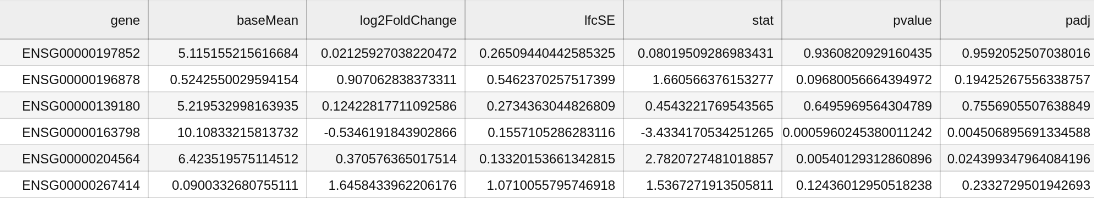
  
- Volcano plots of ```log2FoldChange``` vs ```-log10(pvalue)```

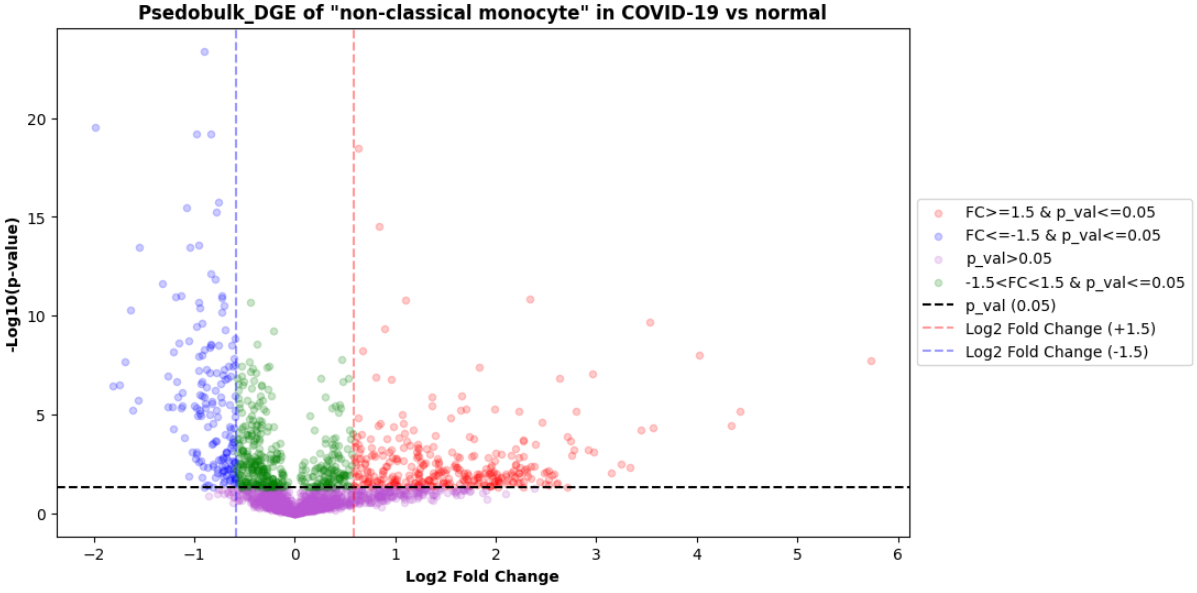
    

  

## <span style="color: steelblue;">2. DGE analysis : Linear mixed effects model (LMEM)</span>

- A linear mixed-effects model can incorporate both fixed and random effects. Fixed effects remain consistent across the population, while random effects vary across different groups or levels within the data and are modeled as random variables with their own distribution, typically assumed to follow a normal distribution.
- In scRNA-seq data, these effects allow the model to treat certain parameters as random variables at the subject level, while fixing others at a higher level, such as the population mean for a clinical condition.
- In the same dataset, we will explore both fixed and random effects parameters and conduct differential gene expression analysis, taking these effects into account.

### <span style="color: steelblue;">2.1 Analysis</span>

- We'll select a subset of cell types for the differential gene expression (DGE) analysis. Next, we'll subset the ```AnnData``` object for each cell type individually. The final linear mixed-effects model (LMEM) analysis will use the ```disease``` column as the ```fixed effect``` parameter and ```donor_id``` as the ```random effect``` or ```group``` parameter. The required and optional parameters are listed below.

In [32]:
dge_lm = dge_lmem.DgeLMEM(fixed_effect_column = 'disease',
                        fixed_effect_factors = ['COVID-19', 'normal'],
                        group = 'donor_id',
                        celltype_column = 'cell_type',
                        cell_subsets = ['non-classical monocyte', 'natural killer cell'],
                        min_cell_threshold = 10,
                        n_cpu = 4,
                        gene_batch_size = 1000,
                        coef_threshold = 0,
                        p_val = 0.05,
                        save_plot = True)

#### <span style="color: steelblue;">2.1.1 Parameters </span>
- (* marked are required)
   
    - *```fixed_effect_column``` : Column name in ```anndata.obs``` containing different factor levels or categories for
      differential gene expression analysis. This serves as the ```fixed_effect``` parameter.           
    - *```fixed_effect_factors``` : List of conditions in ```fixed_effect_column``` used to create the design matrix, with the last
      category in the list serving as the reference to others. For example, in ```['disease_1','disease_2','normal']```,
      ```normal``` serves as the reference.
    - *```group``` : Column name to act as a ```random_effect``` parameter for mixed effect model.
    - *```celltype_column``` : Column name in ```anndata.obs``` containing all the cell types. Analysis can be done without this
      parameter, i.e. without susetting the input data as per the celltypes, but it is better to fix the data with a particular
      celltype to remove the cell specific confounding effects.  
    - *```cell_subsets``` : Selcted list of cell types in ```celltype_column``` to subset the anndata.
    - ```min_cell_threshold``` : Minimum number of cells with nonzero values for a gene.
    - ```n_cpu``` : Number of CPUs for parallelization.
    - ```gene_batch_size``` : Number of genes in a batch of processing.
    - ```coef_threshold``` : Threshold to filter up and down regulated genes in volcano plot.
    - ```p_val``` : ```p```value to filter differentially expressed genes for volcano plot.
    - ```y_lim_tuple``` : Values to adjust the Y-axis limits of the plot.
    - ```save_plot``` : Boolean value to save the plot.

In [ ]:
#Generate analysis and save the result
dge_lm.generate_analysis(adata,dirpath)

### <span style="color: steelblue;">2.2 Result</span>
- Model results for each gene in ```non-classicalmonocyte```
    - ```gene``` - Gene name
    - ```coef_COVID-19``` : Coefficient difference of ```COVID-19``` compared to ```normal``` subjects
    - ```SEcoef_COVID-19``` : Coefficient Standard Error
    - ```pval_COVID-19``` : ```p``` value
    - ```stat_COVID-19``` : ```Wald's test``` statistics
    - ```adj_pval_COVID-19``` : Adjusted ```p``` value

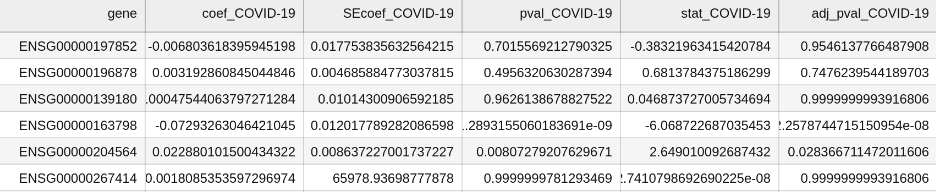

- Volcano plot of ```coef_COVID-19``` vs ```-log10(pval_COVID-19)```

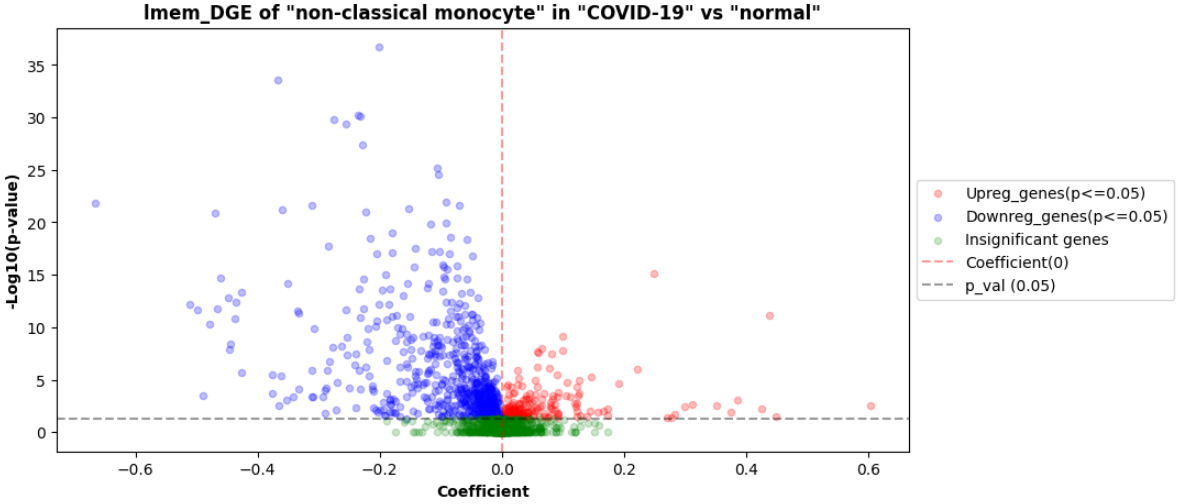

## <span style="color: steelblue;">3. Dge analysis for large Anndata with Nohang Up</span>

- For running the ```DgePseudoBulk/DgeLMEM``` analysis as a Python script, move to the ```tutorials/analysis/differential_gene_expression/``` directory.
  In ```dge_config.yaml```, update the ```dge_type``` and ```psedobulk/lmem_params```. ```dirpath``` and ```full_datapath``` represent the paths to save the results and the AnnData file, respectively.

- ```dge_config.yaml``` for ```DgePseudoBulk```

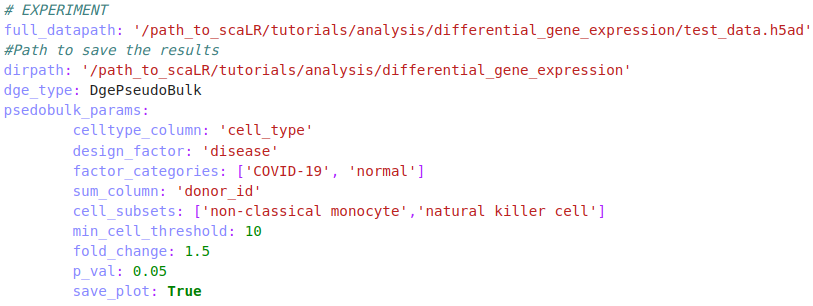

- ```dge_config.yaml``` for ```DgeLMEM```
  
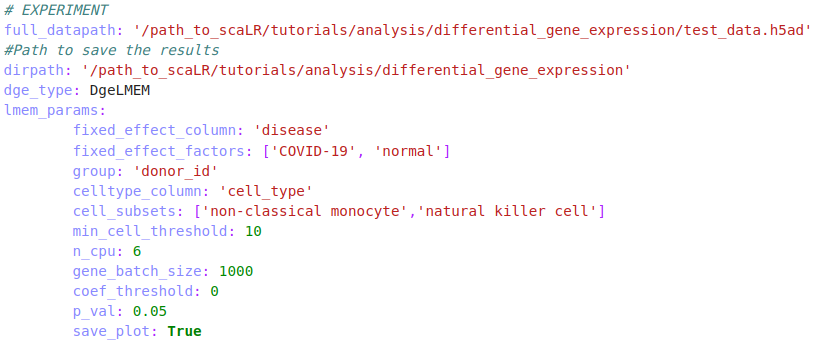

- In ```dge_pseudobulk_main.py/dge_lmem_main.py```, please update the system path in the library section
    - Change ```sys.path.append('/home/amit.samal/scaLR_run/pipeline_latest/single_cell_classification/')``` to ```sys.path.append(/path_to_the_scalr/)```.

- Run either of the commands below in the terminal asper the ```dge_type```:
    - ```nohup /usr/bin/time --verbose python -u dge_pseudobulk_main.py --config dge_config.yaml >nohup_dge_pbk 2>&1 &``` 
    - ```nohup /usr/bin/time --verbose python -u dge_lmem_main.py --config dge_config.yaml >nohup_dge_lmem 2>&1 &```

## <span style="color: steelblue;">4. Comparision of results of Pseudobulk and LMEM </span>


In [80]:
# Pseudobulk and LMEM result for 'non-classical monocyte'
pbk_result_ncm = pd.read_csv(f'{dirpath}/pseudobulk_dge_result/pbkDGE_non-classicalmonocyte_COVID-19_vs_normal.csv')

lmem_result_ncm = pd.read_csv(f'{dirpath}/lmem_dge_result/lmem_DGE_non-classicalmonocyte.csv')

In [81]:
pbk_result_ncm.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000197852,5.115155,0.021259,0.265094,0.080195,0.936082,0.959205
1,ENSG00000196878,0.524255,0.907063,0.546237,1.660566,0.096801,0.194253
2,ENSG00000139180,5.219533,0.124228,0.273436,0.454322,0.649597,0.755691
3,ENSG00000163798,10.108332,-0.534619,0.155711,-3.433417,0.000596,0.004507
4,ENSG00000204564,6.423520,0.370576,0.133202,2.782073,0.005401,0.024399


In [82]:
lmem_result_ncm.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19
0,ENSG00000197852,-0.006804,0.017754,7.015569e-01,-0.383220,9.546138e-01
1,ENSG00000196878,0.003193,0.004686,4.956321e-01,0.681378,7.476240e-01
2,ENSG00000139180,0.000475,0.010143,9.626139e-01,0.046874,1.000000e+00
3,ENSG00000163798,-0.072933,0.012018,1.289316e-09,-6.068723,2.257874e-08
4,ENSG00000204564,0.022880,0.008637,8.072792e-03,2.649010,2.836671e-02


In [83]:
#Adding column with absolute values for 'log2FoldChange' and 'SEcoef_COVID-19' in the dataframes 
pbk_result_ncm['abs_log2FoldChange'] = np.abs(pbk_result_ncm['log2FoldChange'])
lmem_result_ncm['abs_coef_COVID-19'] = np.abs(lmem_result_ncm['coef_COVID-19'])

In [84]:
pbk_result_ncm.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,abs_log2FoldChange
0,ENSG00000197852,5.115155,0.021259,0.265094,0.080195,0.936082,0.959205,0.021259
1,ENSG00000196878,0.524255,0.907063,0.546237,1.660566,0.096801,0.194253,0.907063
2,ENSG00000139180,5.219533,0.124228,0.273436,0.454322,0.649597,0.755691,0.124228
3,ENSG00000163798,10.108332,-0.534619,0.155711,-3.433417,0.000596,0.004507,0.534619
4,ENSG00000204564,6.423520,0.370576,0.133202,2.782073,0.005401,0.024399,0.370576


In [85]:
lmem_result_ncm.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19,abs_coef_COVID-19
0,ENSG00000197852,-0.006804,0.017754,7.015569e-01,-0.383220,9.546138e-01,0.006804
1,ENSG00000196878,0.003193,0.004686,4.956321e-01,0.681378,7.476240e-01,0.003193
2,ENSG00000139180,0.000475,0.010143,9.626139e-01,0.046874,1.000000e+00,0.000475
3,ENSG00000163798,-0.072933,0.012018,1.289316e-09,-6.068723,2.257874e-08,0.072933
4,ENSG00000204564,0.022880,0.008637,8.072792e-03,2.649010,2.836671e-02,0.022880


In [86]:
fold_change = 1.5
log2_fc = np.log2(fold_change)
p_val = 0.05
coef_threshold = 0

In [93]:
#Getting stats for up and down regulated genes in Pseudobulk result
pbk_up_reg_gene_df = pbk_result_ncm.loc[(pbk_result_ncm['log2FoldChange']>=log2_fc)&(pbk_result_ncm['pvalue']<=p_val)]

pbk_down_reg_gene_df = pbk_result_ncm.loc[(pbk_result_ncm['log2FoldChange']<=(-log2_fc))&(pbk_result_ncm['pvalue']<=p_val)]

In [94]:
#Getting stats for up and down regulated genes in LMEM result
lmem_up_reg_gene_df = lmem_result_ncm.loc[(lmem_result_ncm['coef_COVID-19']>coef_threshold)&(lmem_result_ncm['pval_COVID-19']<=p_val)]

lmem_down_reg_gene_df = lmem_result_ncm.loc[(lmem_result_ncm['coef_COVID-19']<(-coef_threshold))&(lmem_result_ncm['pval_COVID-19']<=p_val)]

In [95]:
lmem_up_reg_gene_df.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19,abs_coef_COVID-19
4,ENSG00000204564,0.022880,0.008637,8.072792e-03,2.649010,2.836671e-02,0.022880
7,ENSG00000116717,0.016479,0.007927,3.761531e-02,2.079022,9.990552e-02,0.016479
8,ENSG00000085117,0.086346,0.027959,2.013436e-03,3.088243,8.639326e-03,0.086346
9,ENSG00000092140,0.029451,0.012981,2.328447e-02,2.268735,6.861116e-02,0.029451
13,ENSG00000140853,0.064870,0.011365,1.145002e-08,5.707719,1.655257e-07,0.064870


In [96]:
lmem_down_reg_gene_df.head()

,gene,coef_COVID-19,SEcoef_COVID-19,pval_COVID-19,stat_COVID-19,adj_pval_COVID-19,abs_coef_COVID-19
3,ENSG00000163798,-0.072933,0.012018,1.289316e-09,-6.068723,2.257874e-08,0.072933
10,ENSG00000125877,-0.080259,0.017435,4.159940e-06,-4.603227,3.627737e-05,0.080259
12,ENSG00000170430,-0.073958,0.014333,2.468163e-07,-5.160101,2.754623e-06,0.073958
16,ENSG00000228427,-0.019110,0.004500,2.172907e-05,-4.246340,1.646281e-04,0.019110
22,ENSG00000133872,-0.426107,0.089677,2.018471e-06,-4.751566,1.842283e-05,0.426107


### <span style="color: steelblue;">4.1 Upregulated genes in COVID-19 : Pseudobulk v/s LMEM</span>

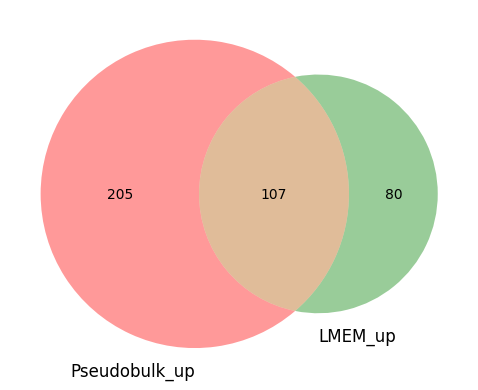

In [102]:
venn2([set(pbk_up_reg_gene_df['gene']), set(lmem_up_reg_gene_df['gene'])], set_labels=('Pseudobulk_up', 'LMEM_up'))

### <span style="color: steelblue;">4.2 Down-regulated genes in COVID-19 : Pseudobulk v/s LMEM</span>

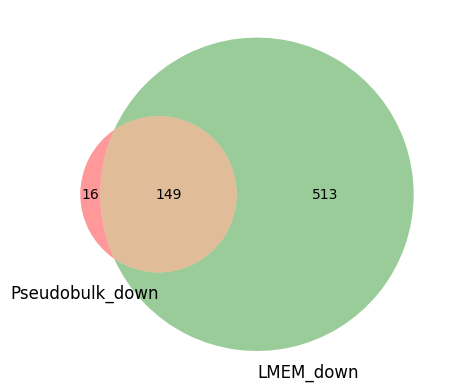

In [103]:
venn2([set(pbk_down_reg_gene_df['gene']), set(lmem_down_reg_gene_df['gene'])], set_labels=('Pseudobulk_down', 'LMEM_down'))